<a href="https://colab.research.google.com/github/phycem/Dark-Matter-Astrophysics-project/blob/main/Training_Image_Augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## To make the process of comparing models with transformations and no transformations faster, I am training the models with one epoch. 

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
import os
import numpy as np
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST
import json
from sklearn.metrics import classification_report
import cv2
import numpy as np
import matplotlib.pyplot as plt

# **MNIST DATASET TRANSFORMATIONS**

In [ ]:
#@title Noisy MNIST Test Dataset 
# Define the gamma value
gamma = 0.2

# Define the number of samples and image shape
n_samples = 500
img_shape = (28, 28)

# Define the digits to generate noise maps for
digits = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

def generate_noise_maps_per_digit(digit, n_samples, gamma, img_shape=(28, 28)):
    noise_maps = []
    labels = []
    mnist_dataset = MNIST(root='data/',train=False, download=True)
    digit_indices = np.where(np.array(mnist_dataset.targets) == digit)[0]
    digit_indices = digit_indices[:n_samples]
    for idx in digit_indices:
        # Get original image
        img = mnist_dataset.data[idx].numpy()
        # Generate random noise
        noise = np.random.randn(*img_shape)
        # Combine noise with original image
        noisy_img = gamma * noise + (1 - gamma) * img
        noise_maps.append(noisy_img)
        labels.append(digit)
    return np.array(noise_maps), np.array(labels)

# Generate noise maps for each digit and average them
noise_maps=[]
labels=[]
for digit in digits:
    digit_noise_maps, digit_labels = generate_noise_maps_per_digit(digit, n_samples, gamma, img_shape=(28,28))
    noise_maps.append(digit_noise_maps)
    labels.append(digit_labels)

all_noise_maps = np.concatenate(noise_maps)
all_labels = np.concatenate(labels)

#**Without any transformation**

In [ ]:
#@title Model code MNIST 
# Set device to CUDA if available, otherwise use CPU
device = tf.device('/gpu:0' if tf.test.is_gpu_available() else '/cpu:0')

# Load MNIST dataset
(train_images, train_labels), (test_images, test_labels) = keras.datasets.mnist.load_data()

# Reshape and normalize data
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32') / 255.0
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1).astype('float32') / 255.0

# Define the model architecture
model = models.Sequential([
    layers.Conv2D(20, kernel_size=5, activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPooling2D(pool_size=2),
    layers.Conv2D(50, kernel_size=5, activation='relu'),
    layers.MaxPooling2D(pool_size=2),
    layers.Flatten(),
    layers.Dense(500, activation='relu'),
    layers.Dense(10, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Define callbacks
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath='best_model.h5',
        save_weights_only=True,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True
    )
]

# Train the model without data augmentation
history = model.fit(train_images, train_labels, batch_size=32, epochs=1, validation_data=(test_images, test_labels), callbacks=callbacks)

# Load best weights
model.load_weights('best_model.h5')

# Save the model to a file
model.save('my_model.h5')


1875/1875 [==============================] - 87s 46ms/step - loss: 0.1155 - accuracy: 0.9648 - val_loss: 0.0428 - val_accuracy: 0.9865


#**Performance metrics:** 
##The second method of performance metrics which prints training accuracy, validation accuracy, training loss, and validation loss is using the original test set of images and their corresponding labels to evaluate the model's performance. The first method which prints test accuracy only is using a new dataset of noise maps and their corresponding labels to evaluate the model's ability to generalize to new, unseen data.

## The model is performing better on the validation data than on the training data. It is generally desirable for the validation accuracy to be higher and the validation loss to be lower than the training accuracy and loss, but it is also important to ensure that the model is not overfitting to the validation set by testing it on an unknown dataset such as noisy images.  

## **1. model:**
###It behaves slightly poor (~0.0057 score lower) on noisy images because the training of the model was without any transformations to become sensitive to any unusual pattern. 

### As we know if the scores on the test set are significantly lower than the validation set, it may indicate overfitting to the validation set. Here the test dataset (noisy images) score is slightly lower (0.98) than validation score (0.986). **The model is overftting to the validation set.**

## **2. model:**

### It behaves on noisy test images slightly better than the non-noisy test images but just a 0.0008 score difference. 


## **Comparison between 1. and 2. model:**

### 2. model behaves better on noisy images with good amount of differences from 0.98 accuracy score to 0.989. Similar applies to test dataset.

### Overall model 2 validation (test set) metrics are better than model 1 and vise versa for the model 1 on training set.

## In conclusion model is improved.

In [ ]:
#@title Print out training and validation metrics
print("Training accuracy: ", history.history['accuracy'])
print("Validation accuracy: ", history.history['val_accuracy'])
print("Training loss: ", history.history['loss'])
print("Validation loss: ", history.history['val_loss'])

Training accuracy:  [0.9630166888237]
Validation accuracy:  [0.9857000112533569]
Training loss:  [0.1188448816537857]
Validation loss:  [0.04449794441461563]


In [ ]:
#@title Model metrics on Noisy images MNIST test set
# Preprocess noise maps
all_noise_maps = all_noise_maps.astype('float32') / 255.0

# Evaluate the model on noise maps dataset
score = model.evaluate(all_noise_maps, all_labels, verbose=0)

# Print the test accuracy
print('Test accuracy:', score[1])

Test accuracy: 0.9800000190734863


In [ ]:
#@title  Make predictions on test data

y_pred = np.argmax(model.predict(test_images), axis=-1)

# Generate classification report
from sklearn.metrics import classification_report
report = classification_report(test_labels, y_pred)
print(report)


313/313 [==============================] - 4s 13ms/step
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       980
           1       0.99      1.00      0.99      1135
           2       0.99      0.99      0.99      1032
           3       0.96      1.00      0.98      1010
           4       1.00      0.99      0.99       982
           5       0.99      0.95      0.97       892
           6       1.00      0.98      0.99       958
           7       0.98      0.99      0.98      1028
           8       0.99      0.99      0.99       974
           9       0.99      0.97      0.98      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



# **Transform as a shift, rotation, zoom, and horizontal flip**

#After running the model for different transformation variables. One is found to be the **best accuracy as given in the first line below picture**.This is much better than no transformation val_accuracy: 0.9857.  Also there are other values which has slight decimal different from the best transformation variables values. 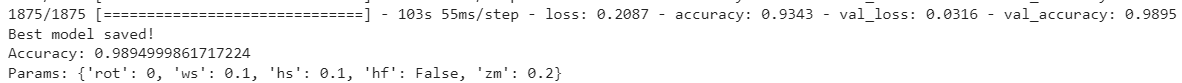 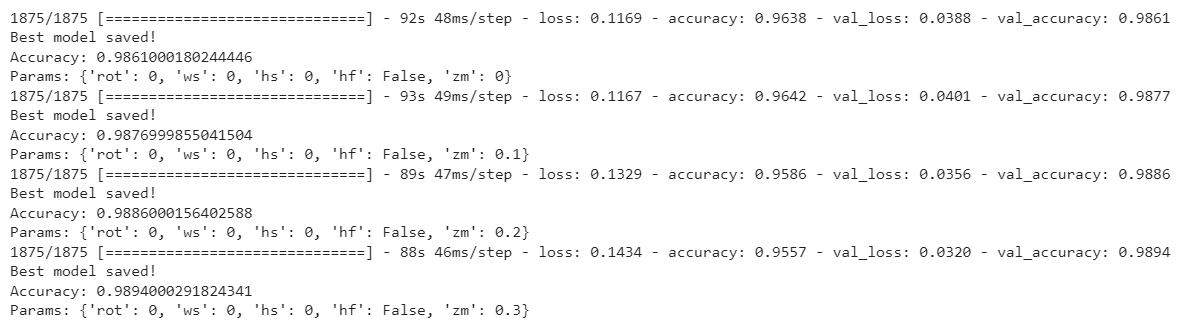

# I have tried making the **image blurring parameters** but it gives significantly lower accuracy rates instead I used gaussian blurring much after that at the end, the best model. The parameters for that are **channel_shift_range = [5, 10, 30] and brightness_range = [0.9, 1.0]** and even lower than that. **The brightness_range makes the modeling performance significantly poor.** Here is what channel_shift_range changed models performance look like: 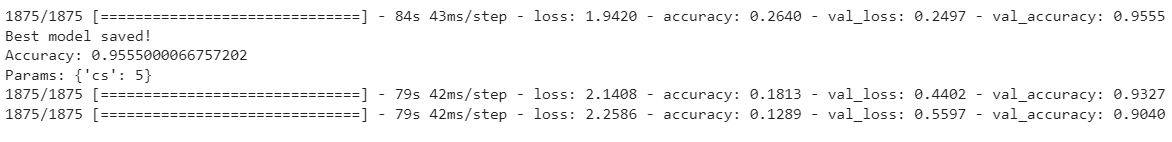 

#It is also observed that **after adding the channel to parameters** for shifting rotating and so on, it is **lowering the model performance significantly** hence these **image blurring parameters should not be used**. 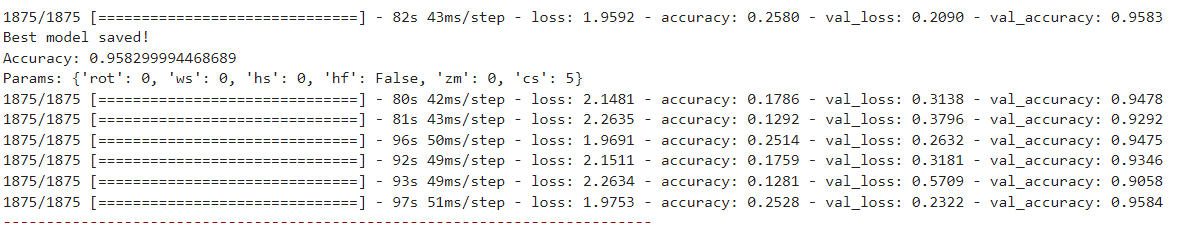

## **Training for different parameter combinations of shift, rotation, zoom, and horizontal flip**

In [ ]:
#@title model code for looping over for different combinations of shift, rotation, zoom, and horizontal flip
# Set device to CUDA if available, otherwise use CPU
device = tf.device('/gpu:0' if tf.test.is_gpu_available() else '/cpu:0')

# Load MNIST dataset
(train_images, train_labels), (test_images, test_labels) = keras.datasets.mnist.load_data()

# Reshape and normalize data
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32') / 255.0
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1).astype('float32') / 255.0

# Define the range of transformation values
rotation_range = [0, 15, 30, 45]
width_shift_range = [0, 0.1, 0.15, 0.2]
height_shift_range = [0, 0.1, 0.15, 0.2]
horizontal_flip = [False, True]
zoom_range = [0, 0.1, 0.2, 0.3]

# Initialize variables to store best accuracy and corresponding model
best_accuracy = 0
best_model = None
best_params = None

# Loop through all possible combinations of transformation values
for rot in rotation_range:
    for ws in width_shift_range:
        for hs in height_shift_range:
            for hf in horizontal_flip:
                for zm in zoom_range:
                    # Define the data augmentation
                    train_image_generator = ImageDataGenerator(
                        rotation_range=rot,
                        width_shift_range=ws,
                        height_shift_range=hs,
                        horizontal_flip=hf,
                        zoom_range=zm
                    )

                    # Define the model architecture
                    model = models.Sequential([
                        layers.Conv2D(20, kernel_size=5, activation='relu', input_shape=(28, 28, 1)),
                        layers.MaxPooling2D(pool_size=2),
                        layers.Conv2D(50, kernel_size=5, activation='relu'),
                        layers.MaxPooling2D(pool_size=2),
                        layers.Flatten(),
                        layers.Dense(500, activation='relu'),
                        layers.Dense(10, activation='softmax')
                    ])

                    # Compile the model
                    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

                    # Define callbacks
                    callbacks = [
                        keras.callbacks.ModelCheckpoint(
                            filepath='best_model.h5',
                            save_weights_only=True,
                            monitor='val_accuracy',
                            mode='max',
                            save_best_only=True
                        )
                    ]

                    # Train the model with data augmentation
                    history = model.fit(train_image_generator.flow(train_images, train_labels, batch_size=32), epochs=1, validation_data=(test_images, test_labels), callbacks=callbacks)

                    # Load best weights
                    model.load_weights('best_model.h5')

                    # Evaluate the model on test data
                    score = model.evaluate(test_images, test_labels, verbose=0)
                    accuracy = score[1]

                    # Update best accuracy and corresponding model
                    if accuracy > best_accuracy:
                        best_accuracy = accuracy
                        best_model = model
                        best_params = {'rot': rot, 'ws': ws, 'hs': hs, 'hf': hf, 'zm': zm}
                        print("Best model saved!")
                        print('Accuracy:', best_accuracy)
                        print('Params:', best_params)

# Save the best model and its parameters to a file
best_model.save('best_model.h5')
with open('best_model_params.json', 'w') as f:
    json.dump(best_params, f)

1875/1875 [==============================] - 92s 48ms/step - loss: 0.1169 - accuracy: 0.9638 - val_loss: 0.0388 - val_accuracy: 0.9861
Best model saved!
Accuracy: 0.9861000180244446
Params: {'rot': 0, 'ws': 0, 'hs': 0, 'hf': False, 'zm': 0}
1875/1875 [==============================] - 93s 49ms/step - loss: 0.1167 - accuracy: 0.9642 - val_loss: 0.0401 - val_accuracy: 0.9877
Best model saved!
Accuracy: 0.9876999855041504
Params: {'rot': 0, 'ws': 0, 'hs': 0, 'hf': False, 'zm': 0.1}
1875/1875 [==============================] - 89s 47ms/step - loss: 0.1329 - accuracy: 0.9586 - val_loss: 0.0356 - val_accuracy: 0.9886
Best model saved!
Accuracy: 0.9886000156402588
Params: {'rot': 0, 'ws': 0, 'hs': 0, 'hf': False, 'zm': 0.2}
1875/1875 [==============================] - 88s 46ms/step - loss: 0.1434 - accuracy: 0.9557 - val_loss: 0.0320 - val_accuracy: 0.9894
Best model saved!
Accuracy: 0.9894000291824341
Params: {'rot': 0, 'ws': 0, 'hs': 0, 'hf': False, 'zm': 0.3}
1875/1875 [===================

# After comparing the ranges of parameters, I played around the next decimal points of the parameters to get the best performance. The model reaches to **0.9917** sensitivity - the value later fluctuated when I run the model again but it is still higher than the no transformation.And it performs better on noisy images with **0.04** sensitivity difference.

In [ ]:
#@title BEST IMAGE AUGMENTATION MODEL (the image blurring is the next one)
# Set device to CUDA if available, otherwise use CPU
device = tf.device('/gpu:0' if tf.test.is_gpu_available() else '/cpu:0')

# Load MNIST dataset
(train_images, train_labels), (test_images, test_labels) = keras.datasets.mnist.load_data()

# Reshape and normalize data
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32') / 255.0
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1).astype('float32') / 255.0

# Define the data augmentation
train_image_generator = ImageDataGenerator(
    rotation_range=0.15,
    width_shift_range=.065,
    height_shift_range=.065,
    horizontal_flip=False,
    zoom_range=0.25
)

# Define the model architecture
model = models.Sequential([
    layers.Conv2D(20, kernel_size=5, activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPooling2D(pool_size=2),
    layers.Conv2D(50, kernel_size=5, activation='relu'),
    layers.MaxPooling2D(pool_size=2),
    layers.Flatten(),
    layers.Dense(500, activation='relu'),
    layers.Dense(10, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Define callbacks
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath='best_model.h5',
        save_weights_only=True,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True
    )
]

# Train the model with data augmentation
history = model.fit(train_image_generator.flow(train_images, train_labels, batch_size=32), epochs=1, validation_data=(test_images, test_labels), callbacks=callbacks)

# Load best weights
model.load_weights('best_model.h5')

# Save the model to a file
model.save('my_model.h5')



1875/1875 [==============================] - 94s 49ms/step - loss: 0.1930 - accuracy: 0.9404 - val_loss: 0.0341 - val_accuracy: 0.9887


In [ ]:
#@title Print out training and validation metrics

print("Training accuracy: ", history.history['accuracy'])
print("Validation accuracy: ", history.history['val_accuracy'])
print("Training loss: ", history.history['loss'])
print("Validation loss: ", history.history['val_loss'])

Training accuracy:  [0.940416693687439]
Validation accuracy:  [0.9886999726295471]
Training loss:  [0.19298064708709717]
Validation loss:  [0.03413693606853485]


**Note**: if you run and see a low score 0.10, please go up and run the noise generator generate_noise_maps_per_digit function again. It should give a score around 0.925 or just around 0.9.

In [ ]:
#@title noisy MNIST test dataset model accuracy
# Preprocess noise maps
all_noise_maps = all_noise_maps.astype('float32') / 255.0

# Evaluate the model on noise maps dataset
score = model.evaluate(all_noise_maps, all_labels, verbose=0)

# Print the test accuracy
print('Test accuracy:', score[1])


Test accuracy: 0.984000027179718


In [ ]:
#@title MNIST test set prediction
# Make predictions on test data
y_pred = np.argmax(model.predict(test_images), axis=-1)

# Generate classification report
from sklearn.metrics import classification_report
report = classification_report(test_labels, y_pred)
print(report)


313/313 [==============================] - 4s 12ms/step
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      1.00      1.00      1135
           2       0.99      0.99      0.99      1032
           3       0.99      0.99      0.99      1010
           4       0.99      0.98      0.98       982
           5       0.98      0.99      0.99       892
           6       0.99      0.99      0.99       958
           7       0.99      0.98      0.99      1028
           8       0.98      0.99      0.99       974
           9       0.98      0.98      0.98      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



# Here I am adding **blurring on the training pictures** using Gaussian blur with a kernel size of 5x5 and a sigma of 0.5 

## Comparing with 0 rotation and 0.15 rotation, zero rotation performs better on noisy images with the gaussian blur.

## The prediction sensitivity improved 0.09 score for the noisy images.



In [ ]:
#@title Blur added model for MNIST dataset with transformation
# Set device to CUDA if available, otherwise use CPU
device = tf.device('/gpu:0' if tf.test.is_gpu_available() else '/cpu:0')

# Load MNIST dataset
(train_images, train_labels), (test_images, test_labels) = keras.datasets.mnist.load_data()

# Reshape and normalize data
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32') / 255.0
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1).astype('float32') / 255.0


# Loop through all training images
for i in range(len(train_images)):
    # Apply Gaussian blur with a kernel size of 5x5 and a sigma of 0.5
    blurred = cv2.GaussianBlur(train_images[i], (5, 5), 0.5)
    # Add extra dimension to match the shape of train_images
    blurred = np.expand_dims(blurred, axis=-1)
    # Store the blurred image back in the train_images array
    train_images[i] = blurred



# Define the data augmentation
train_image_generator = ImageDataGenerator(
    rotation_range=0.15,
    width_shift_range=.065,
    height_shift_range=.065,
    horizontal_flip=False,
    zoom_range=0.25
)

# Define the model architecture
model1 = models.Sequential([
    layers.Conv2D(20, kernel_size=5, activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPooling2D(pool_size=2),
    layers.Conv2D(50, kernel_size=5, activation='relu'),
    layers.MaxPooling2D(pool_size=2),
    layers.Flatten(),
    layers.Dense(500, activation='relu'),
    layers.Dense(10, activation='softmax')
])

# Compile the model
model1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Define callbacks
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath='best_model1.h5',
        save_weights_only=True,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True
    )
]

# Train the model with data augmentation
history = model1.fit(train_image_generator.flow(train_images, train_labels, batch_size=32), epochs=1, validation_data=(test_images, test_labels), callbacks=callbacks)

# Load best weights
model1.load_weights('best_model1.h5')

# Save the model to a file
model1.save('my_model1.h5')

1875/1875 [==============================] - 111s 58ms/step - loss: 0.1841 - accuracy: 0.9429 - val_loss: 0.0330 - val_accuracy: 0.9897


In [ ]:
#@title test accuracy of noisy MNIST test dataset
# Preprocess noise maps
all_noise_maps = all_noise_maps.astype('float32') / 255.0

# Evaluate the model on noise maps dataset
score = model.evaluate(all_noise_maps, all_labels, verbose=0)

# Print the test accuracy
print('Test accuracy:', score[1])


Test accuracy: 0.984000027179718


#**BEST IMAGE TRANSFORMATION MODEL**

In [ ]:
#@title MNIST BEST TRANSFORMATION WITH GAUSSIAN BLUR 
# Set device to CUDA if available, otherwise use CPU
device = tf.device('/gpu:0' if tf.test.is_gpu_available() else '/cpu:0')

# Load MNIST dataset
(train_images, train_labels), (test_images, test_labels) = keras.datasets.mnist.load_data()

# Reshape and normalize data
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32') / 255.0
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1).astype('float32') / 255.0


# Loop through all training images
for i in range(len(train_images)):
    # Apply Gaussian blur with a kernel size of 5x5 and a sigma of 0.5
    blurred = cv2.GaussianBlur(train_images[i], (5, 5), 0.5)
    # Add extra dimension to match the shape of train_images
    blurred = np.expand_dims(blurred, axis=-1)
    # Store the blurred image back in the train_images array
    train_images[i] = blurred



# Define the data augmentation
train_image_generator = ImageDataGenerator(
    rotation_range=0,
    width_shift_range=.065,
    height_shift_range=.065,
    horizontal_flip=False,
    zoom_range=0.25
)

# Define the model architecture
model1 = models.Sequential([
    layers.Conv2D(20, kernel_size=5, activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPooling2D(pool_size=2),
    layers.Conv2D(50, kernel_size=5, activation='relu'),
    layers.MaxPooling2D(pool_size=2),
    layers.Flatten(),
    layers.Dense(500, activation='relu'),
    layers.Dense(10, activation='softmax')
])

# Compile the model
model1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Define callbacks
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath='best_model1.h5',
        save_weights_only=True,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True
    )
]

# Train the model with data augmentation
history = model1.fit(train_image_generator.flow(train_images, train_labels, batch_size=32), epochs=1, validation_data=(test_images, test_labels), callbacks=callbacks)

# Load best weights
model1.load_weights('best_model1.h5')

# Save the model to a file
model1.save('my_model1.h5')



1875/1875 [==============================] - 63s 33ms/step - loss: 0.1915 - accuracy: 0.9399 - val_loss: 0.0433 - val_accuracy: 0.9872


In [ ]:
#@title test dataset model performance 

# Make predictions on test data
y_pred = np.argmax(model1.predict(test_images), axis=-1)

# Generate classification report
report = classification_report(test_labels, y_pred)
print(report)


313/313 [==============================] - 3s 9ms/step
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       980
           1       1.00      0.98      0.99      1135
           2       0.99      1.00      0.99      1032
           3       0.98      0.99      0.99      1010
           4       0.99      0.99      0.99       982
           5       0.99      0.99      0.99       892
           6       0.98      0.99      0.99       958
           7       0.98      0.99      0.98      1028
           8       0.99      0.98      0.99       974
           9       1.00      0.97      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



In [ ]:
#@title Print out training and validation metrics

print("Training accuracy: ", history.history['accuracy'])
print("Validation accuracy: ", history.history['val_accuracy'])
print("Training loss: ", history.history['loss'])
print("Validation loss: ", history.history['val_loss'])

Training accuracy:  [0.9421166777610779]
Validation accuracy:  [0.9883000254631042]
Training loss:  [0.18542160093784332]
Validation loss:  [0.03367670625448227]


In [ ]:
#@title Noisy image MNIST test set model performance
# Preprocess noise maps
all_noise_maps = all_noise_maps.astype('float32') / 255.0

# Evaluate the model on noise maps dataset
score = model.evaluate(all_noise_maps, all_labels, verbose=0)

# Print the test accuracy
print('Test accuracy:', score[1])


Test accuracy: 0.9891999959945679


## Plots CNN layer activations: second convolutional layer and the max pooling actually which shows us activations from first convolutional layer.

## **LAYER ACTIVATION BAR PLOTS**

In [ ]:
#@title Plot function code
def plot_mean_activation_maps(model, model_name, input_images, all_labels):
    # Define a new Model to get intermediate representations for all layers in the previous model after the first.
    successive_outputs = [layer.output for layer in model.layers[1:]]
    visualization_model = tf.keras.models.Model(inputs=model.input, outputs=successive_outputs)

    # Get the intermediate representations for real data
    successive_feature_maps_real = visualization_model.predict(input_images)

    # Retrieve the names of the layers
    layer_names = [layer.name for layer in model.layers]

    # Define lists to store the mean activation maps for each layer and class
    mean_activation_maps = []
    num_classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

    # Loop over the layers
    for layer_name, feature_map_real in zip(layer_names, successive_feature_maps_real):
        if 'conv' not in layer_name:
            continue

        # Get the number of filters in the current layer
        n_filters = feature_map_real.shape[-1]

        # Define a list to store the mean activation maps for the current layer
        layer_mean_activation_maps = []

        # Loop over the classes
        for class_idx in num_classes:
            # Select the feature maps that correspond to the target class
            target_indices = np.where(all_labels == class_idx)[0]
            feature_maps_real = feature_map_real[target_indices]

            # Get the mean activation maps for real data and noise data separately
            mean_activation_map_real = np.mean(feature_maps_real, axis=(0,1,2))

            # Add the mean activation map to the list for the current layer
            layer_mean_activation_maps.append(mean_activation_map_real)

        # Compute the average mean activation map across all classes for the current layer
        layer_mean_activation_maps = np.array(layer_mean_activation_maps)
        mean_activation_map = np.mean(layer_mean_activation_maps, axis=0)

        # Add the average mean activation map to the list of mean activation maps for all layers
        mean_activation_maps.append(mean_activation_map)

    # Plot the mean activation maps for all convolutional layers
    fig, axs = plt.subplots(ncols=len(mean_activation_maps), figsize=(20, 4))
    for i, mean_activation_map in enumerate(mean_activation_maps):
      axs[i].set_title(f"Mean Activation Map ({layer_names[i+1]})")
      axs[i].bar(range(len(mean_activation_map)), mean_activation_map)
    plt.show()

Model without transformations
157/157 [==============================] - 3s 20ms/step


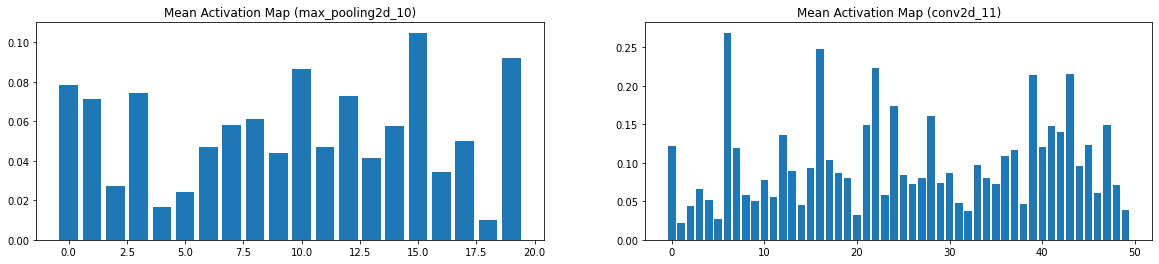

Model with transformations
157/157 [==============================] - 2s 11ms/step


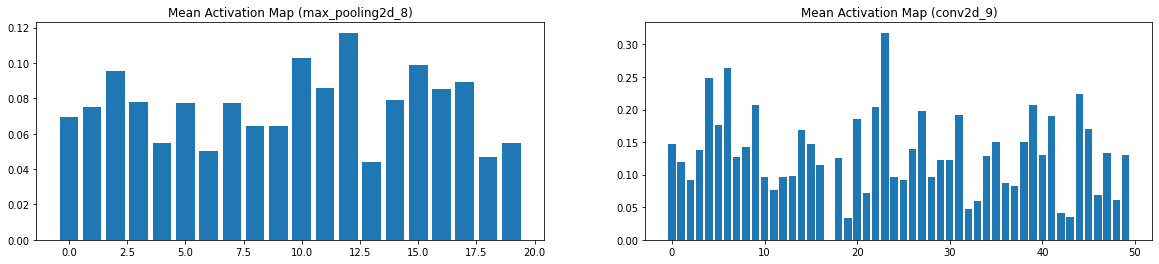

In [ ]:
#@title Calling plot functions for the models
# Create a new array to store the reshaped images
input_images = np.zeros((all_noise_maps.shape[0], 28, 28, 1))

# Reshape each image to (1, 28, 28, 1) and store in input_images
for i in range(all_noise_maps.shape[0]):
    input_images[i] = all_noise_maps[i].reshape(28, 28, 1)

print("Model without transformations")
# Plot mean activation maps for model
plot_mean_activation_maps(model, "Model", input_images, all_labels)

print("Model with transformations")
# Plot mean activation maps for model1
plot_mean_activation_maps(model1, "W/ Transformations", input_images, all_labels)


## **ACTIVATION LAYER LINE PLOTS**

In [ ]:
#@title Plot function code
def get_mean_activation_maps(model, input_images, labels):
    # Define a new Model to get intermediate representations for all layers in the previous model after the first.
    successive_outputs = [layer.output for layer in model.layers[1:]]
    visualization_model = tf.keras.models.Model(inputs=model.input, outputs=successive_outputs)

    # Get the intermediate representations for real data
    successive_feature_maps_real = visualization_model.predict(input_images)

    # Retrieve the names of the layers
    layer_names = [layer.name for layer in model.layers]

    # Define lists to store the mean activation maps for each layer and class
    mean_activation_maps = []
    num_classes = np.unique(labels)

    # Loop over the layers
    for layer_name, feature_map_real in zip(layer_names, successive_feature_maps_real):
        if 'conv' not in layer_name:
            continue

        # Get the number of filters in the current layer
        n_filters = feature_map_real.shape[-1]

        # Define a list to store the mean activation maps for the current layer
        layer_mean_activation_maps = []

        # Loop over the classes
        for class_idx in num_classes:
            # Select the feature maps that correspond to the target class
            target_indices = np.where(labels == class_idx)[0]
            feature_maps_real = feature_map_real[target_indices]

            # Get the mean activation maps for real data and noise data separately
            mean_activation_map_real = np.mean(feature_maps_real, axis=(0,1,2))

            # Add the mean activation map to the list for the current layer
            layer_mean_activation_maps.append(mean_activation_map_real)

        # Compute the average mean activation map across all classes for the current layer
        layer_mean_activation_maps = np.array(layer_mean_activation_maps)
        mean_activation_map = np.mean(layer_mean_activation_maps, axis=0)

        # Add the average mean activation map to the list of mean activation maps for all layers
        mean_activation_maps.append(mean_activation_map)

    return mean_activation_maps, layer_names

def plot_mean_activation_maps_for_models(model1, model2, input_images, labels):
    # Get mean activation maps and layer names for both models
    mean_activation_maps1, layer_names1 = get_mean_activation_maps(model1, input_images, labels)
    mean_activation_maps2, layer_names2 = get_mean_activation_maps(model2, input_images, labels)

    # Plot the average mean activation maps for all layers for both models
    plt.figure(figsize=(50,20))
    plt.suptitle("Average Mean Activation Maps for all Layers")
    plt.subplots_adjust(wspace=0.3)
    for i, (mean_activation_map1, mean_activation_map2) in enumerate(zip(mean_activation_maps1, mean_activation_maps2)):
        plt.subplot(2, 4, i+1)
        plt.plot(range(len(mean_activation_map1)), mean_activation_map1, label="Model without transformations")
        plt.plot(range(len(mean_activation_map2)), mean_activation_map2, label="Model with transformations")
        plt.title(layer_names1[i+1])
        plt.legend()
    plt.show()


157/157 [==============================] - 2s 11ms/step


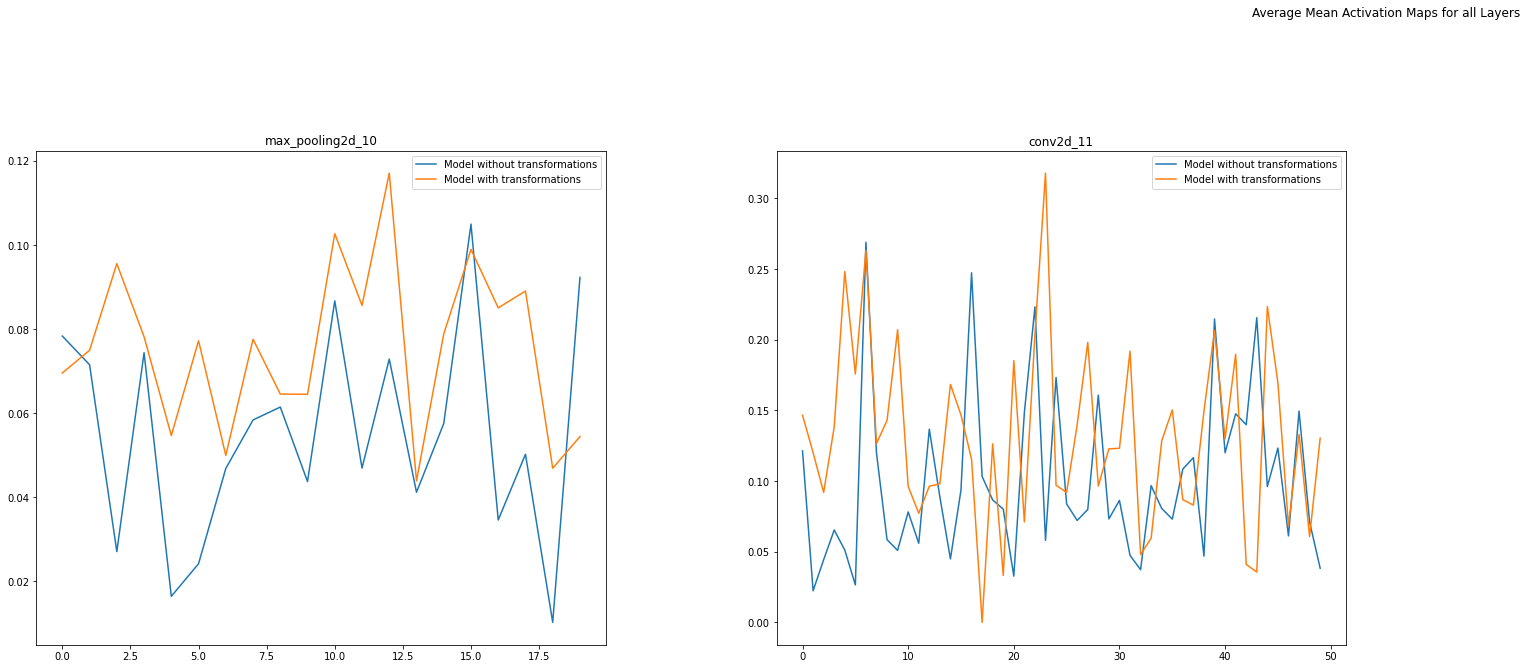

In [ ]:
plot_mean_activation_maps_for_models(model, model1, input_images, all_labels)

# **Fashion-MNIST DATASET TRANSFORMATIONS**

In [ ]:
#@title create noisy images for Fashion-MNIST
# Define the gamma value
gamma = 0.2

# Define the number of samples and image shape
n_samples = 500
img_shape = (28, 28)

# Define the classes
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal',
           'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Define transformation to normalize the data
transform = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    samplewise_center=True,
    samplewise_std_normalization=True
)

# Load test dataset
(test_images, test_labels), _ = tf.keras.datasets.fashion_mnist.load_data()
testset = tf.data.Dataset.from_tensor_slices((test_images.reshape(-1, 28, 28, 1), test_labels))

def generate_noise_maps_per_class(cls, n_samples, gamma, img_shape=(28, 28)):
    noise_maps = []
    labels = []
    class_indices = np.where(np.array(test_labels) == cls)[0]
    class_indices = class_indices[:n_samples]
    print(f"Number of images for class {classes[cls]}: {len(class_indices)}")
    for idx in class_indices:
        # Get original image
        img = test_images[idx]
        # Generate random noise
        noise = np.random.randn(*img_shape)
        # Combine noise with original image
        noisy_img = gamma * noise + (1 - gamma) * img
        noise_maps.append(noisy_img)
        labels.append(cls)
    return np.array(noise_maps) , np.array(labels)

# Generate noise maps for each class and average them
noise_maps=[]
avgd_noise_maps = []
labels = []
for cls in range(len(classes)):
    class_noise_maps , class_names = generate_noise_maps_per_class(cls, n_samples, gamma, img_shape=(28,28))
    noise_maps.append(class_noise_maps)
    labels.append(class_names)

all_noise_maps = np.concatenate(noise_maps)
all_labels = np.concatenate(labels)

4422102/4422102 [==============================] - 0s 0us/step
Number of images for class T-shirt/top: 500
Number of images for class Trouser: 500
Number of images for class Pullover: 500
Number of images for class Dress: 500
Number of images for class Coat: 500
Number of images for class Sandal: 500
Number of images for class Shirt: 500
Number of images for class Sneaker: 500
Number of images for class Bag: 500
Number of images for class Ankle boot: 500


# Channel shift is again not a good transformation: 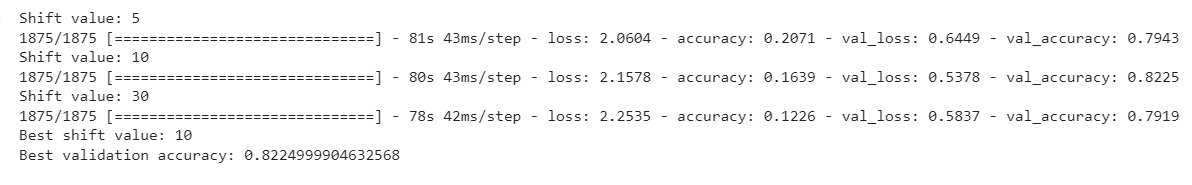

# Brightness range in  0.1, 0.5, 0.7, 1.0 gives also poor training results as below: 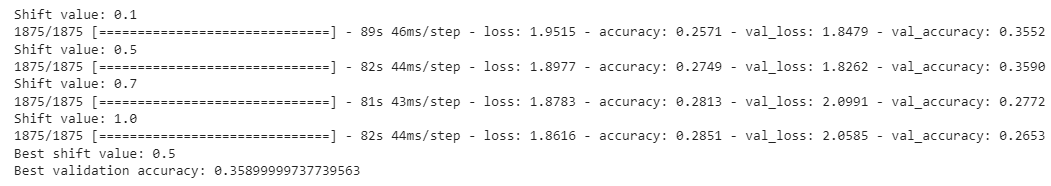

#**Without any transformation**

In [ ]:
#@title No transformation model Fashion-MNIST Training
# Set device to CUDA if available, otherwise use CPU
device = tf.device('/gpu:0' if tf.test.is_gpu_available() else '/cpu:0')

# Load MNIST dataset
(train_images, train_labels), (test_images, test_labels) = keras.datasets.fashion_mnist.load_data()

# Reshape and normalize data
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32') / 255.0
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1).astype('float32') / 255.0

# Define the model architecture
model = models.Sequential([
    layers.Conv2D(20, kernel_size=5, activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPooling2D(pool_size=2),
    layers.Conv2D(50, kernel_size=5, activation='relu'),
    layers.MaxPooling2D(pool_size=2),
    layers.Flatten(),
    layers.Dense(500, activation='relu'),
    layers.Dense(10, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Define callbacks
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath='best_model.h5',
        save_weights_only=True,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True
    )
]

# Train the model without data augmentation
history = model.fit(train_images, train_labels, batch_size=32, epochs=1, validation_data=(test_images, test_labels), callbacks=callbacks)

# Load best weights
model.load_weights('best_model.h5')

# Save the model to a file
model.save('my_model.h5')

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


1875/1875 [==============================] - 85s 44ms/step - loss: 0.4455 - accuracy: 0.8366 - val_loss: 0.3662 - val_accuracy: 0.8663


In [ ]:
#@title Print out training and validation metrics
print("Training accuracy: ", history.history['accuracy'])
print("Validation accuracy: ", history.history['val_accuracy'])
print("Training loss: ", history.history['loss'])
print("Validation loss: ", history.history['val_loss'])


Training accuracy:  [0.8425999879837036]
Validation accuracy:  [0.8726000189781189]
Training loss:  [0.4342677593231201]
Validation loss:  [0.34967634081840515]


In [ ]:
#@title Make predictions on test data
y_pred = np.argmax(model.predict(test_images), axis=-1)

# Generate classification report
from sklearn.metrics import classification_report
report = classification_report(test_labels, y_pred)
print(report)

313/313 [==============================] - 5s 14ms/step
              precision    recall  f1-score   support

           0       0.75      0.90      0.82      1000
           1       0.99      0.96      0.98      1000
           2       0.71      0.91      0.80      1000
           3       0.88      0.90      0.89      1000
           4       0.84      0.71      0.77      1000
           5       0.98      0.96      0.97      1000
           6       0.78      0.48      0.60      1000
           7       0.92      0.97      0.95      1000
           8       0.95      0.98      0.96      1000
           9       0.97      0.95      0.96      1000

    accuracy                           0.87     10000
   macro avg       0.88      0.87      0.87     10000
weighted avg       0.88      0.87      0.87     10000



In [ ]:
#@title accuracy on noisy MNIST 
# Preprocess noise maps
all_noise_maps = all_noise_maps.astype('float32') / 255.0

# Evaluate the model on noise maps dataset
score = model.evaluate(all_noise_maps, all_labels, verbose=0)

# Print the test accuracy
print('Test accuracy:', score[1])


Test accuracy: 0.8593999743461609


# **Transform as a shift, rotation, zoom, and horizontal flip**

## **1. Run** It is time consuming to run all the combinations for different parameter values. I decided to check each parameter and pick the best performing from each based on accuracy on the next line.

In [ ]:
#@title Running all the combinations of different parameter values of image augmentation which is more than 700 
# Set device to CUDA if available, otherwise use CPU
device = tf.device('/gpu:0' if tf.test.is_gpu_available() else '/cpu:0')

# Load MNIST dataset
(train_images, train_labels), (test_images, test_labels) = keras.datasets.fashion_mnist.load_data()

# Reshape and normalize data
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32') / 255.0
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1).astype('float32') / 255.0

# Define the model architecture
model = models.Sequential([
    layers.Conv2D(20, kernel_size=5, activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPooling2D(pool_size=2),
    layers.Conv2D(50, kernel_size=5, activation='relu'),
    layers.MaxPooling2D(pool_size=2),
    layers.Flatten(),
    layers.Dense(500, activation='relu'),
    layers.Dense(10, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Define callbacks
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath='best_model.h5',
        save_weights_only=True,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True
    )
]

# Define data augmentation
rotation_range = [0, 15, 30, 45]
width_shift_range = [0, 0.1, 0.15, 0.2]
height_shift_range = [0, 0.1, 0.15, 0.2]
shear_range = [0, 0.1, 0.2, 0.3]
zoom_range = [0, 0.1, 0.2, 0.3]
horizontal_flip = [False, True]

best_accuracy = 0.0

for rotation in rotation_range:
    for width_shift in width_shift_range:
        for height_shift in height_shift_range:
            for shear in shear_range:
                for zoom in zoom_range:
                    for flip in horizontal_flip:
                        datagen = ImageDataGenerator(
                            rotation_range=rotation,
                            width_shift_range=width_shift,
                            height_shift_range=height_shift,
                            shear_range=shear,
                            zoom_range=zoom,
                            horizontal_flip=flip,
                            vertical_flip=False,
                        )
                        aug_train_images = datagen.flow(train_images, train_labels, batch_size=32)
                        history = model.fit(aug_train_images, epochs=1, validation_data=(test_images, test_labels), callbacks=callbacks)
                        val_accuracy = history.history['val_accuracy'][-1]
                        if val_accuracy > best_accuracy:
                            best_accuracy = val_accuracy
                            best_rotation = rotation
                            best_width_shift = width_shift
                            best_height_shift = height_shift
                            best_shear = shear
                            best_zoom = zoom
                            best_flip = flip
                            best_model = model
                            best_params = {'best_rotation': rotation, 'best_width_shift ': width_shift, 'best_height_shift ': height_shift, 'best_shear': shear, 'best_zoom': zoom, 'best_flip':flip}
                            print("Best model saved!")
                            print('Accuracy:', best_accuracy)
                            print('Params:', best_params)

# Save the best model and its parameters to a file
best_model.save('best_model.h5')
with open('best_model_params.json', 'w') as f:
    json.dump(best_params, f)




1875/1875 [==============================] - 107s 55ms/step - loss: 0.4519 - accuracy: 0.8353 - val_loss: 0.3687 - val_accuracy: 0.8641
Best model saved!
Accuracy: 0.8640999794006348
Params: {'best_rotation': 0, 'best_width_shift ': 0, 'best_height_shift ': 0, 'best_shear': 0, 'best_zoom': 0, 'best_flip': False}
1875/1875 [==============================] - 75s 40ms/step - loss: 0.3319 - accuracy: 0.8791 - val_loss: 0.3410 - val_accuracy: 0.8749
Best model saved!
Accuracy: 0.8748999834060669
Params: {'best_rotation': 0, 'best_width_shift ': 0, 'best_height_shift ': 0, 'best_shear': 0, 'best_zoom': 0, 'best_flip': True}
1875/1875 [==============================] - 87s 47ms/step - loss: 0.3019 - accuracy: 0.8868 - val_loss: 0.2920 - val_accuracy: 0.8911
Best model saved!
Accuracy: 0.8910999894142151
Params: {'best_rotation': 0, 'best_width_shift ': 0, 'best_height_shift ': 0, 'best_shear': 0, 'best_zoom': 0.1, 'best_flip': False}
1875/1875 [==============================] - 86s 46ms/step 

## Below code is comparing each parameter with various values and printing the parameter with its value. Here it recognizes rotation, width, hight and shear but not zooming and horizontal flip. As in the **1. Run**, the best models can be any horizontal situation False or True. So, I will disregard horizontal flip. I check right below this code, zoom parameters if there is any improvement using itself alone. 

## From this running we get: 

## 'rotation_range': 15
## 'width_shift_range': 0.1
## 'height_shift_range': 0
## 'shear_range': 0.1

In [ ]:
#@title Comparison of each parameter with various values and picking the best next performance
# Set device to CUDA if available, otherwise use CPU
device = tf.device('/gpu:0' if tf.test.is_gpu_available() else '/cpu:0')

# Load MNIST dataset
(train_images, train_labels), (test_images, test_labels) = keras.datasets.fashion_mnist.load_data()

# Reshape and normalize data
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32') / 255.0
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1).astype('float32') / 255.0

# Define the model architecture
model = models.Sequential([
    layers.Conv2D(20, kernel_size=5, activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPooling2D(pool_size=2),
    layers.Conv2D(50, kernel_size=5, activation='relu'),
    layers.MaxPooling2D(pool_size=2),
    layers.Flatten(),
    layers.Dense(500, activation='relu'),
    layers.Dense(10, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Define callbacks
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath='best_model.h5',
        save_weights_only=True,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True
    )
]

# Define data augmentation
params = {
    'rotation_range': [0, 15, 30, 45],
    'width_shift_range': [0, 0.1, 0.15, 0.2],
    'height_shift_range': [0, 0.1, 0.15, 0.2],
    'shear_range': [0, 0.1, 0.2, 0.3],
    'zoom_range': [0, 0.1, 0.2, 0.3],
    'horizontal_flip': [False, True]
}

best_accuracy = 0.0

for param_name, param_values in params.items():
    for param_value in param_values:
        # Create a dictionary with the current parameter name and value
        current_params = {param_name: param_value}

        # Create an ImageDataGenerator with the current parameter value
        datagen = ImageDataGenerator(**current_params, 
                                      vertical_flip=False)

        # Augment the training data with the current parameter value
        aug_train_images = datagen.flow(train_images, train_labels, batch_size=32)

        # Train the model on the augmented data
        history = model.fit(aug_train_images, epochs=1, validation_data=(test_images, test_labels), callbacks=callbacks)

        # Get the validation accuracy of the model after training
        val_accuracy = history.history['val_accuracy'][-1]

        # If the current model's accuracy is better than the previous best, save the model and its parameters
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            best_param_name = param_name
            best_param_value = param_value
            best_model = model
            best_params = {best_param_name: best_param_value}
            print("Best model saved!")
            print('Accuracy:', best_accuracy)
            print('Params:', best_params)


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


1875/1875 [==============================] - 79s 42ms/step - loss: 0.4455 - accuracy: 0.8390 - val_loss: 0.3403 - val_accuracy: 0.8788
Best model saved!
Accuracy: 0.8787999749183655
Params: {'rotation_range': 0}
1875/1875 [==============================] - 89s 48ms/step - loss: 0.3546 - accuracy: 0.8684 - val_loss: 0.3273 - val_accuracy: 0.8830
Best model saved!
Accuracy: 0.8830000162124634
Params: {'rotation_range': 15}
1875/1875 [==============================] - 78s 41ms/step - loss: 0.2587 - accuracy: 0.9036 - val_loss: 0.2790 - val_accuracy: 0.8980
Best model saved!
Accuracy: 0.8980000019073486
Params: {'width_shift_range': 0}
1875/1875 [==============================] - 86s 46ms/step - loss: 0.2843 - accuracy: 0.8909 - val_loss: 0.2758 - val_accuracy: 0.9015
Best model saved!
Accuracy: 0.9014999866485596
Params: {'width_shift_range': 0.1}
1875/1875 [==============================] - 74s 39ms/step - loss: 0.1947 - accuracy: 0.9267 - val_loss: 0.2562 - val_accuracy: 0.9110
Best mod

In [ ]:
#@title Here I am training the model for different zoom parameters. Zooming for 0.2 giving 0.888 accuracy is the best. I am coding the best transformation below with zooming included., rotation,width
# Set device to CUDA if available, otherwise use CPU
device = tf.device('/gpu:0' if tf.test.is_gpu_available() else '/cpu:0')

# Load MNIST dataset
(train_images, train_labels), (test_images, test_labels) = keras.datasets.fashion_mnist.load_data()

# Reshape and normalize data
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32') / 255.0
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1).astype('float32') / 255.0

# Define the model architecture
model = models.Sequential([
    layers.Conv2D(20, kernel_size=5, activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPooling2D(pool_size=2),
    layers.Conv2D(50, kernel_size=5, activation='relu'),
    layers.MaxPooling2D(pool_size=2),
    layers.Flatten(),
    layers.Dense(500, activation='relu'),
    layers.Dense(10, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Define callbacks
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath='best_model.h5',
        save_weights_only=True,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True
    )
]

# Define data augmentation
params = {
    'zoom_range': [0, 0.1, 0.2, 0.3]
}

best_accuracy = 0.0

for param_name, param_values in params.items():
    for param_value in param_values:
        # Create a dictionary with the current parameter name and value
        current_params = {param_name: param_value}

        # Create an ImageDataGenerator with the current parameter value
        datagen = ImageDataGenerator(**current_params)

        # Augment the training data with the current parameter value
        aug_train_images = datagen.flow(train_images, train_labels, batch_size=32)

        # Train the model on the augmented data
        history = model.fit(aug_train_images, epochs=1, validation_data=(test_images, test_labels), callbacks=callbacks)

        # Get the validation accuracy of the model after training
        val_accuracy = history.history['val_accuracy'][-1]

        # If the current model's accuracy is better than the previous best, save the model and its parameters
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            best_param_name = param_name
            best_param_value = param_value
            best_model = model
            best_params = {best_param_name: best_param_value}
            print("Best model saved!")
            print('Accuracy:', best_accuracy)
            print('Params:', best_params)


1875/1875 [==============================] - 90s 48ms/step - loss: 0.4413 - accuracy: 0.8404 - val_loss: 0.3458 - val_accuracy: 0.8738
Best model saved!
Accuracy: 0.8737999796867371
Params: {'zoom_range': 0}
1875/1875 [==============================] - 106s 57ms/step - loss: 0.3328 - accuracy: 0.8772 - val_loss: 0.3271 - val_accuracy: 0.8833
Best model saved!
Accuracy: 0.8833000063896179
Params: {'zoom_range': 0.1}
1875/1875 [==============================] - 95s 51ms/step - loss: 0.3374 - accuracy: 0.8732 - val_loss: 0.3060 - val_accuracy: 0.8883
Best model saved!
Accuracy: 0.8883000016212463
Params: {'zoom_range': 0.2}
1875/1875 [==============================] - 99s 53ms/step - loss: 0.3599 - accuracy: 0.8652 - val_loss: 0.3341 - val_accuracy: 0.8792


In [ ]:
#@title Brightness range
# Set device to CUDA if available, otherwise use CPU
device = tf.device('/gpu:0' if tf.test.is_gpu_available() else '/cpu:0')

# Load MNIST dataset
(train_images, train_labels), (test_images, test_labels) = keras.datasets.fashion_mnist.load_data()

# Reshape and normalize data
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32') / 255.0
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1).astype('float32') / 255.0

# Define the model architecture
model = models.Sequential([
    layers.Conv2D(20, kernel_size=5, activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPooling2D(pool_size=2),
    layers.Conv2D(50, kernel_size=5, activation='relu'),
    layers.MaxPooling2D(pool_size=2),
    layers.Flatten(),
    layers.Dense(500, activation='relu'),
    layers.Dense(10, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Define callbacks
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath='best_model.h5',
        save_weights_only=True,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True
    )
]

# Define data augmentation
datagen = ImageDataGenerator(
    brightness_range=(0.0, 0.0)  # initially set to 0.0
)

# Train the model with data augmentation and select the best model
best_accuracy = 0.0
best_shift = 0
for shift in [0.1, 0.5, 0.7, 1.0]:
    print(f"Shift value: {shift}")
    datagen.brightness_range = (1.0 - shift, 1.0 + shift)
    aug_train_images = datagen.flow(train_images, train_labels, batch_size=32)
    history = model.fit(aug_train_images, epochs=1, validation_data=(test_images, test_labels), callbacks=callbacks)
    val_accuracy = history.history['val_accuracy'][-1]
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        best_shift = shift

# Load best weights
model.load_weights('best_model.h5')

# Save the model to a file
model.save('my_model.h5')

print(f"Best shift value: {best_shift}")
print(f"Best validation accuracy: {best_accuracy}")


Shift value: 0.1
1875/1875 [==============================] - 89s 46ms/step - loss: 1.9515 - accuracy: 0.2571 - val_loss: 1.8479 - val_accuracy: 0.3552
Shift value: 0.5
1875/1875 [==============================] - 82s 44ms/step - loss: 1.8977 - accuracy: 0.2749 - val_loss: 1.8262 - val_accuracy: 0.3590
Shift value: 0.7
1875/1875 [==============================] - 81s 43ms/step - loss: 1.8783 - accuracy: 0.2813 - val_loss: 2.0991 - val_accuracy: 0.2772
Shift value: 1.0
1875/1875 [==============================] - 82s 44ms/step - loss: 1.8616 - accuracy: 0.2851 - val_loss: 2.0585 - val_accuracy: 0.2653
Best shift value: 0.5
Best validation accuracy: 0.35899999737739563


# **BEST IMAGE AUGMENTATION FOR FASHION-MNIST DATASET MODEL** (image blurring is the next then the best model is presented)
 ## Accuracy improves in small bits

In [ ]:
#@title before image blurring with image augmentation model code
# Set device to CUDA if available, otherwise use CPU
device = tf.device('/gpu:0' if tf.test.is_gpu_available() else '/cpu:0')

# Load MNIST dataset
(train_images, train_labels), (test_images, test_labels) = keras.datasets.fashion_mnist.load_data()

# Reshape and normalize data
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32') / 255.0
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1).astype('float32') / 255.0

# Define the model architecture
model = models.Sequential([
    layers.Conv2D(20, kernel_size=5, activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPooling2D(pool_size=2),
    layers.Conv2D(50, kernel_size=5, activation='relu'),
    layers.MaxPooling2D(pool_size=2),
    layers.Flatten(),
    layers.Dense(500, activation='relu'),
    layers.Dense(10, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Define callbacks
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath='best_model.h5',
        save_weights_only=True,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True
    )
]

# Define data augmentation
datagen = ImageDataGenerator(
    zoom_range=0.18,
    rotation_range=1,
    width_shift_range=0.08,
    shear_range=0.08
)

# Augment the training data with the current parameter value
aug_train_images = datagen.flow(train_images, train_labels, batch_size=32)

# Train the model on the augmented data
history = model.fit(aug_train_images, epochs=1, validation_data=(test_images, test_labels), callbacks=callbacks)

# Get the validation accuracy of the model after training
val_accuracy = history.history['val_accuracy'][-1]

print('Accuracy:', val_accuracy)


1875/1875 [==============================] - 97s 51ms/step - loss: 0.5458 - accuracy: 0.7946 - val_loss: 0.3790 - val_accuracy: 0.8564
Accuracy: 0.8564000129699707


In [ ]:
#@title Print out training and validation metrics
# Print out training and validation metrics
print("Training accuracy: ", history.history['accuracy'])
print("Validation accuracy: ", history.history['val_accuracy'])
print("Training loss: ", history.history['loss'])
print("Validation loss: ", history.history['val_loss'])



Training accuracy:  [0.7945833206176758]
Validation accuracy:  [0.8564000129699707]
Training loss:  [0.5457782745361328]
Validation loss:  [0.3790089190006256]


In [ ]:
#@title Make predictions on test data
# Make predictions on test data
y_pred = np.argmax(model.predict(test_images), axis=-1)

# Generate classification report
from sklearn.metrics import classification_report
report = classification_report(test_labels, y_pred)
print(report)

313/313 [==============================] - 3s 10ms/step
              precision    recall  f1-score   support

           0       0.82      0.83      0.82      1000
           1       0.99      0.96      0.98      1000
           2       0.90      0.57      0.70      1000
           3       0.80      0.94      0.86      1000
           4       0.74      0.76      0.75      1000
           5       0.96      0.97      0.97      1000
           6       0.57      0.66      0.61      1000
           7       0.95      0.93      0.94      1000
           8       0.96      0.97      0.96      1000
           9       0.95      0.96      0.96      1000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



In [ ]:
#@title test accuracy on noisy Fashion-MNIST test dataset
# Preprocess noise maps
all_noise_maps = all_noise_maps.astype('float32') / 255.0

# Evaluate the model on noise maps dataset
score = model.evaluate(all_noise_maps, all_labels, verbose=0)

# Print the test accuracy
print('Test accuracy:', score[1])


Test accuracy: 0.86080002784729


# **BEST MODEL FOR FASHION-MNIST DATASET**


# Here I am adding **blurring on the training pictures** using Gaussian blur with a kernel size of 5x5 and a sigma of 0.5 

## Rotation changed to 1 as smaller rotation performs better on noisy images with the gaussian blur.

## The prediction sensitivity improved 0.001 score for the noisy images.



In [ ]:
#@title Best Fashion-MNIST Model code
# Set device to CUDA if available, otherwise use CPU
device = tf.device('/gpu:0' if tf.test.is_gpu_available() else '/cpu:0')

# Load MNIST dataset
(train_images, train_labels), (test_images, test_labels) = keras.datasets.fashion_mnist.load_data()

# Reshape and normalize data
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32') / 255.0
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1).astype('float32') / 255.0


# Loop through all training images
for i in range(len(train_images)):
    # Apply Gaussian blur with a kernel size of 5x5 and a sigma of 0.5
    blurred = cv2.GaussianBlur(train_images[i], (5, 5), 0.3)
    # Add extra dimension to match the shape of train_images
    blurred = np.expand_dims(blurred, axis=-1)
    # Store the blurred image back in the train_images array
    train_images[i] = blurred



# Define the data augmentation
train_image_generator = ImageDataGenerator(
    zoom_range=0.18,
    rotation_range=1,
    width_shift_range=0.08,
    shear_range=0.08
)

# Define the model architecture
model1 = models.Sequential([
    layers.Conv2D(20, kernel_size=5, activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPooling2D(pool_size=2),
    layers.Conv2D(50, kernel_size=5, activation='relu'),
    layers.MaxPooling2D(pool_size=2),
    layers.Flatten(),
    layers.Dense(500, activation='relu'),
    layers.Dense(10, activation='softmax')
])

# Compile the model
model1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Define callbacks
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath='best_model1.h5',
        save_weights_only=True,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True
    )
]

# Train the model with data augmentation
history = model1.fit(train_image_generator.flow(train_images, train_labels, batch_size=32), epochs=1, validation_data=(test_images, test_labels), callbacks=callbacks)

# Load best weights
model1.load_weights('best_model1.h5')

# Save the model to a file
model1.save('my_model1.h5')

1875/1875 [==============================] - 91s 48ms/step - loss: 0.5493 - accuracy: 0.7953 - val_loss: 0.3724 - val_accuracy: 0.8658


In [ ]:
#@title test accuracy on noisy Fashion-MNIST test dataset
# Preprocess noise maps
all_noise_maps = all_noise_maps.astype('float32') / 255.0

# Evaluate the model on noise maps dataset
score = model.evaluate(all_noise_maps, all_labels, verbose=0)

# Print the test accuracy
print('Test accuracy:', score[1])

Test accuracy: 0.8604000210762024


In [ ]:
#@title Print out training and validation metrics

print("Training accuracy: ", history.history['accuracy'])
print("Validation accuracy: ", history.history['val_accuracy'])
print("Training loss: ", history.history['loss'])
print("Validation loss: ", history.history['val_loss'])


Training accuracy:  [0.7986500263214111]
Validation accuracy:  [0.8615999817848206]
Training loss:  [0.5375517010688782]
Validation loss:  [0.37515175342559814]


In [ ]:
#@title Make predictions on test data

y_pred = np.argmax(model.predict(test_images), axis=-1)

# Generate classification report
from sklearn.metrics import classification_report
report = classification_report(test_labels, y_pred)
print(report)

1875/1875 [==============================] - 21s 11ms/step
              precision    recall  f1-score   support

           0       0.84      0.81      0.82      6000
           1       0.97      0.98      0.98      6000
           2       0.92      0.47      0.62      6000
           3       0.82      0.93      0.87      6000
           4       0.62      0.87      0.73      6000
           5       0.93      0.98      0.95      6000
           6       0.62      0.63      0.62      6000
           7       0.97      0.88      0.93      6000
           8       0.97      0.97      0.97      6000
           9       0.95      0.97      0.96      6000

    accuracy                           0.85     60000
   macro avg       0.86      0.85      0.84     60000
weighted avg       0.86      0.85      0.84     60000



# Plot comments:
## There are not huge differences of convolutional layer activations between two models without and with transformations. That is normal since the accuracies are quite similar too

## **LAYER ACTIVATION BAR PLOTS**

In [ ]:
#@title Fashion-MNIST LAYER ACTIVATION CODE
def plot_mean_activation_maps(model, model_name, input_images, all_labels):
    # Define a new Model to get intermediate representations for all layers in the previous model after the first.
    successive_outputs = [layer.output for layer in model.layers[1:]]
    visualization_model = tf.keras.models.Model(inputs=model.input, outputs=successive_outputs)

    # Get the intermediate representations for real data
    successive_feature_maps_real = visualization_model.predict(input_images)

    # Retrieve the names of the layers
    layer_names = [layer.name for layer in model.layers]

    # Define lists to store the mean activation maps for each layer and class
    mean_activation_maps = []
    num_classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

    # Loop over the layers
    for layer_name, feature_map_real in zip(layer_names, successive_feature_maps_real):
        if 'conv' not in layer_name:
            continue

        # Get the number of filters in the current layer
        n_filters = feature_map_real.shape[-1]

        # Define a list to store the mean activation maps for the current layer
        layer_mean_activation_maps = []

        # Loop over the classes
        for class_idx in num_classes:
            # Select the feature maps that correspond to the target class
            target_indices = np.where(all_labels == class_idx)[0]
            feature_maps_real = feature_map_real[target_indices]

            # Get the mean activation maps for real data and noise data separately
            mean_activation_map_real = np.mean(feature_maps_real, axis=(0,1,2))

            # Add the mean activation map to the list for the current layer
            layer_mean_activation_maps.append(mean_activation_map_real)

        # Compute the average mean activation map across all classes for the current layer
        layer_mean_activation_maps = np.array(layer_mean_activation_maps)
        mean_activation_map = np.mean(layer_mean_activation_maps, axis=0)

        # Add the average mean activation map to the list of mean activation maps for all layers
        mean_activation_maps.append(mean_activation_map)

    # Plot the mean activation maps for all convolutional layers
    fig, axs = plt.subplots(ncols=len(mean_activation_maps), figsize=(20, 4))
    for i, mean_activation_map in enumerate(mean_activation_maps):
      axs[i].set_title(f"Mean Activation Map ({layer_names[i+1]})")
      axs[i].bar(range(len(mean_activation_map)), mean_activation_map)
    plt.show()

Model without transformations
157/157 [==============================] - 2s 11ms/step


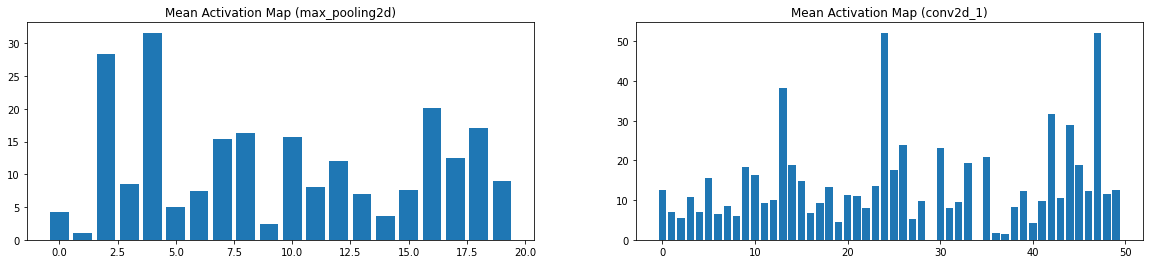

Model with transformations
157/157 [==============================] - 3s 16ms/step


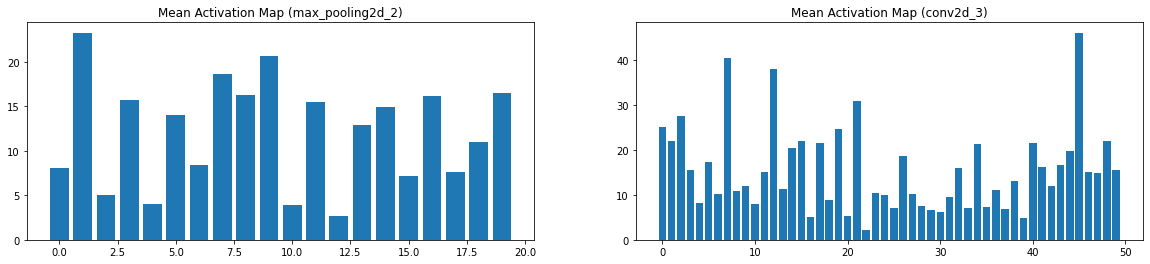

In [ ]:
#@title BAR PLOTS
# Create a new array to store the reshaped images
input_images = np.zeros((all_noise_maps.shape[0], 28, 28, 1))

# Reshape each image to (1, 28, 28, 1) and store in input_images
for i in range(all_noise_maps.shape[0]):
    input_images[i] = all_noise_maps[i].reshape(28, 28, 1)

print("Model without transformations")
# Plot mean activation maps for model
plot_mean_activation_maps(model, "Model", input_images, all_labels)

print("Model with transformations")
# Plot mean activation maps for model1
plot_mean_activation_maps(model1, "W/ Transformations", input_images, all_labels)


## **ACTIVATION LAYER LINE PLOTS**

In [ ]:
#@title Fashion-MNIST ACTIVATION LAYER CODE
def get_mean_activation_maps(model, input_images, labels):
    # Define a new Model to get intermediate representations for all layers in the previous model after the first.
    successive_outputs = [layer.output for layer in model.layers[1:]]
    visualization_model = tf.keras.models.Model(inputs=model.input, outputs=successive_outputs)

    # Get the intermediate representations for real data
    successive_feature_maps_real = visualization_model.predict(input_images)

    # Retrieve the names of the layers
    layer_names = [layer.name for layer in model.layers]

    # Define lists to store the mean activation maps for each layer and class
    mean_activation_maps = []
    num_classes = np.unique(labels)

    # Loop over the layers
    for layer_name, feature_map_real in zip(layer_names, successive_feature_maps_real):
        if 'conv' not in layer_name:
            continue

        # Get the number of filters in the current layer
        n_filters = feature_map_real.shape[-1]

        # Define a list to store the mean activation maps for the current layer
        layer_mean_activation_maps = []

        # Loop over the classes
        for class_idx in num_classes:
            # Select the feature maps that correspond to the target class
            target_indices = np.where(labels == class_idx)[0]
            feature_maps_real = feature_map_real[target_indices]

            # Get the mean activation maps for real data and noise data separately
            mean_activation_map_real = np.mean(feature_maps_real, axis=(0,1,2))

            # Add the mean activation map to the list for the current layer
            layer_mean_activation_maps.append(mean_activation_map_real)

        # Compute the average mean activation map across all classes for the current layer
        layer_mean_activation_maps = np.array(layer_mean_activation_maps)
        mean_activation_map = np.mean(layer_mean_activation_maps, axis=0)

        # Add the average mean activation map to the list of mean activation maps for all layers
        mean_activation_maps.append(mean_activation_map)

    return mean_activation_maps, layer_names

def plot_mean_activation_maps_for_models(model1, model2, input_images, labels):
    # Get mean activation maps and layer names for both models
    mean_activation_maps1, layer_names1 = get_mean_activation_maps(model1, input_images, labels)
    mean_activation_maps2, layer_names2 = get_mean_activation_maps(model2, input_images, labels)

    # Plot the average mean activation maps for all layers for both models
    plt.figure(figsize=(50,20))
    plt.suptitle("Average Mean Activation Maps for all Layers")
    plt.subplots_adjust(wspace=0.3)
    for i, (mean_activation_map1, mean_activation_map2) in enumerate(zip(mean_activation_maps1, mean_activation_maps2)):
        plt.subplot(2, 4, i+1)
        plt.plot(range(len(mean_activation_map1)), mean_activation_map1, label="Model without transformations")
        plt.plot(range(len(mean_activation_map2)), mean_activation_map2, label="Model with transformations")
        plt.title(layer_names1[i+1])
        plt.legend()
    plt.show()


157/157 [==============================] - 2s 10ms/step


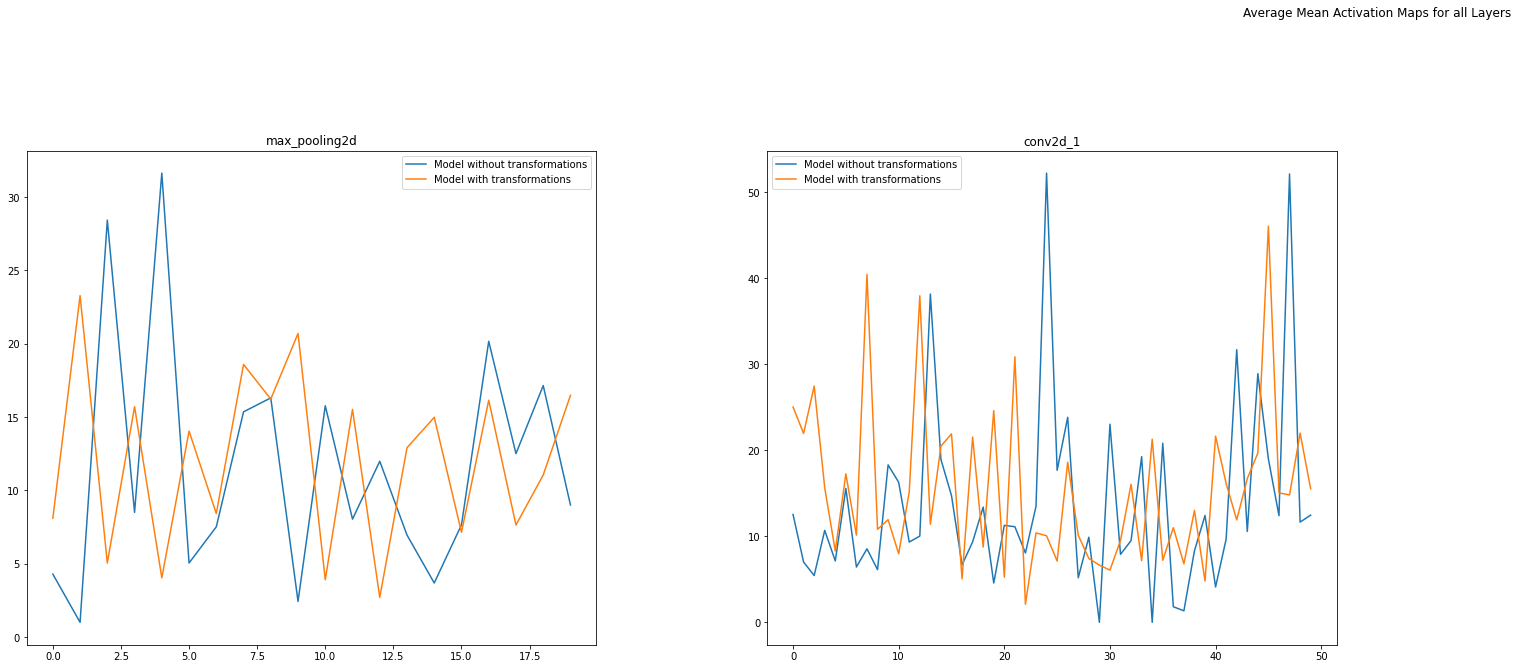

In [ ]:
plot_mean_activation_maps_for_models(model, model1, input_images, all_labels)